In [2]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)


In [3]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

In [4]:
pca_components = pca.components_

In [5]:
pca_n_components = pca.n_components_

In [6]:
pca_variance = pca.explained_variance_ratio_

In [7]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240829'

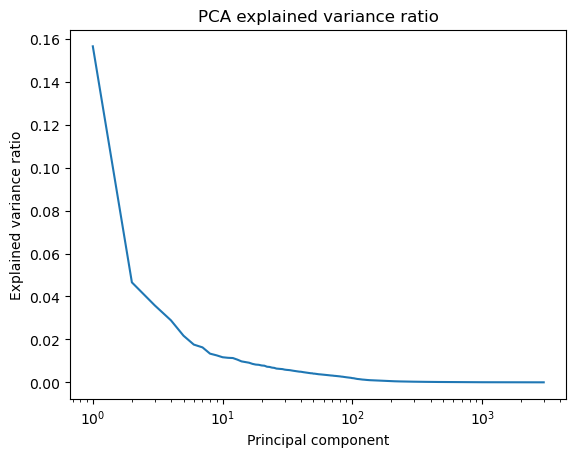

In [8]:
plt.semilogx(np.arange(1, pca_n_components+1), pca_variance)
plt.title('PCA explained variance ratio')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.savefig(os.path.join(save_dir, 'pca_variance_ratio.png'), dpi=300, bbox_inches='tight')


(0.0, 20.0)

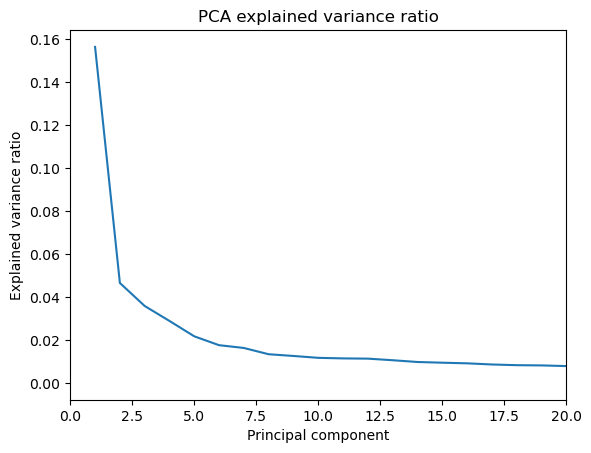

In [9]:
plt.plot(np.arange(1, pca_n_components+1), pca_variance)
plt.title('PCA explained variance ratio')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.xlim([0, 20])
# plt.savefig(os.path.join(save_dir, 'pca_variance_ratio.png'), dpi=300, bbox_inches='tight')


In [10]:
pca_variance_cumsum = np.cumsum(pca_variance)

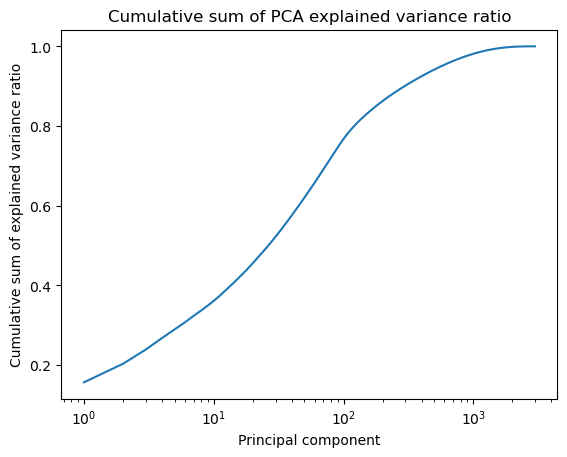

In [11]:
plt.semilogx(np.arange(1, pca_n_components+1), pca_variance_cumsum)
plt.title('Cumulative sum of PCA explained variance ratio')
plt.xlabel('Principal component')
plt.ylabel('Cumulative sum of explained variance ratio')
plt.savefig(os.path.join(save_dir, 'pca_variance_ratio_cumsum.png'), dpi=300, bbox_inches='tight')


Text(0, 0.5, 'Explained variance ratio')

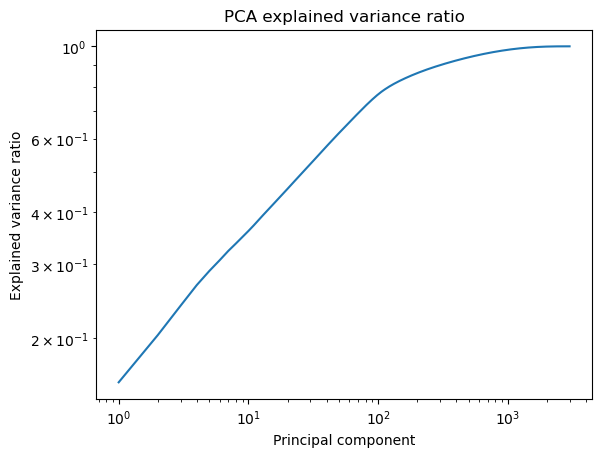

In [12]:
plt.loglog(np.arange(1, pca_n_components+1), pca_variance_cumsum)
plt.title('PCA explained variance ratio')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
# plt.savefig(os.path.join(save_dir, 'pca_variance_ratio.png'), dpi=300, bbox_inches='tight')


In [13]:
# Find the number of components that explain 95% of the variance
explained_variance_ratio_cumsum = np.cumsum(pca_variance)
n_components = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1
n_components

566

In [14]:
n_components/pca_n_components

0.1898054996646546

In [15]:
# Set n_components to 5
n_components = 5

In [16]:
# Choose to project onto the linear subspace produced by the first 566 components 
# Keep the first n_components colummns of the pca_components matrix
esc_maps_pca_reduced = esc_maps_pca[:, :n_components]
cnc_maps_pca_reduced = cnc_maps_pca[:, :n_components]

In [17]:

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca_reduced, columns=['PC{}'.format(i) for i in range(1, n_components+1)])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca_reduced, columns=['PC{}'.format(i) for i in range(1, n_components+1)])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

num_metastructures = 10

# Change this by tiling the whole space instead
# Find the min and max values of all PCs
pc_min_list = []
pc_max_list = []
for i in range(1, n_components+1):
    pc_min_list.append(all_df['PC{}'.format(i)].min())
    pc_max_list.append(all_df['PC{}'.format(i)].max())

pc_min_list = np.array(pc_min_list)
pc_max_list = np.array(pc_max_list)

pc_grid_list = []
for i in range(n_components):
    pc_grid_list.append(np.linspace(pc_min_list[i], pc_max_list[i], num_metastructures))

pc_grid = np.meshgrid(*pc_grid_list)


PC1, PC2, PC3, PC4, PC5 = pc_grid
PC1_flat = PC1.flatten()
PC2_flat = PC2.flatten()
PC3_flat = PC3.flatten()
PC4_flat = PC4.flatten()
PC5_flat = PC5.flatten()
pc_df = pd.DataFrame({'PC1': PC1_flat, 'PC2': PC2_flat, 'PC3': PC3_flat, 'PC4': PC4_flat, 'PC5': PC5_flat})
pc_df.head()
pca_5 = PCA(n_components=5)
pca_5.fit(all_maps_interp_flat)
metastructure = pca_5.inverse_transform(pc_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])
# Find rows with unique combinations of PC1 and PC2

unique_combinations = pc_df.drop_duplicates(subset=['PC1', 'PC2'])

# Sort the unique combinations by PC1 and PC2
# Descending PC2
unique_combinations = unique_combinations.sort_values(by=['PC1', 'PC2'], ascending=[True, False])

metastructure_mean = []
for index, row in unique_combinations.iterrows():
    pc1_value = row['PC1']
    pc2_value = row['PC2']
    
    # Filter the DataFrame for the current combination of PC1 and PC2
    matching_rows = pc_df[(pc_df['PC1'] == pc1_value) & (pc_df['PC2'] == pc2_value)].index
    
    metastructure_mean.append(np.mean(metastructure[matching_rows], axis=0))
    
metastructure_mean = np.array(metastructure_mean)

metastructure_PC1_PC2 = metastructure[unique_indices]
# Plot these metastructure on 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax=axes[i%10, i//10]
    ax.imshow(metastructure_mean[i].reshape(80, 80), cmap='coolwarm', vmin=-1000, vmax=1000)
    
    # axs[i//10, i%10].axis('off')
    # if ax is in the first col, add a y label
    lab = unique_combinations.iloc[i, 1]
    if i // 10 == 0:
        ax.set_ylabel(f'PC2={unique_combinations.iloc[i, 1]:.2f}')
    # if ax is in the last row, add a x label
    if i % 10 == 9:
        ax.set_xlabel(f'PC1={unique_combinations.iloc[i, 0]:.2f}')
        
    # Remove ticks by setting them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title('M{}'.format(i))
plt.savefig(os.path.join(save_dir, 'metastructures_PC1_PC2_unphysical.png'), dpi=300, bbox_inches='tight')
# This requires the metastructures to only cover the actual data

NameError: name 'unique_indices' is not defined

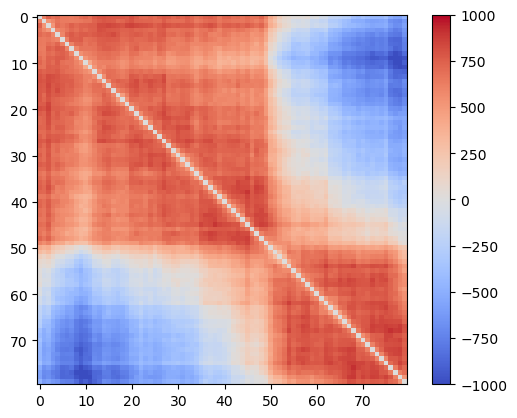

In [ ]:
plt.imshow(metastructure_PC1_PC2[90].reshape(80, 80), cmap='coolwarm', vmin=-1000, vmax=1000)
plt.colorbar()

In [18]:

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca_reduced, columns=['PC{}'.format(i) for i in range(1, n_components+1)])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca_reduced, columns=['PC{}'.format(i) for i in range(1, n_components+1)])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

num_metastructures = 10

# Change this by tiling the whole space instead
# Find the min and max values of all PCs
lower_quantile = 0.05
upper_quantile = 1 - lower_quantile
pc_min_list = []
pc_max_list = []
for i in range(1, n_components+1):
    pc_min_list.append(all_df['PC{}'.format(i)].quantile(lower_quantile))
    pc_max_list.append(all_df['PC{}'.format(i)].quantile(upper_quantile))

pc_min_list = np.array(pc_min_list)
pc_max_list = np.array(pc_max_list)

pc_grid_list = []
for i in range(n_components):
    pc_grid_list.append(np.linspace(pc_min_list[i], pc_max_list[i], num_metastructures))

pc_grid = np.meshgrid(*pc_grid_list)


PC1, PC2, PC3, PC4, PC5 = pc_grid
PC1_flat = PC1.flatten()
PC2_flat = PC2.flatten()
PC3_flat = PC3.flatten()
PC4_flat = PC4.flatten()
PC5_flat = PC5.flatten()
pc_df = pd.DataFrame({'PC1': PC1_flat, 'PC2': PC2_flat, 'PC3': PC3_flat, 'PC4': PC4_flat, 'PC5': PC5_flat})
pc_df.head()
pca_5 = PCA(n_components=5)
pca_5.fit(all_maps_interp_flat)
metastructure = pca_5.inverse_transform(pc_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])
# Find rows with unique combinations of PC1 and PC2
unique_combinations = pc_df.drop_duplicates(subset=['PC1', 'PC2'])

# Sort the unique combinations by PC1 and PC2
# Descending PC2
unique_combinations = unique_combinations.sort_values(by=['PC1', 'PC2'], ascending=[True, False])


In [19]:
metastructure_mean = []
for index, row in unique_combinations.iterrows():
    pc1_value = row['PC1']
    pc2_value = row['PC2']
    
    # Filter the DataFrame for the current combination of PC1 and PC2
    matching_rows = pc_df[(pc_df['PC1'] == pc1_value) & (pc_df['PC2'] == pc2_value)].index
    
    metastructure_mean.append(np.mean(metastructure[matching_rows], axis=0))
    
metastructure_mean = np.array(metastructure_mean)

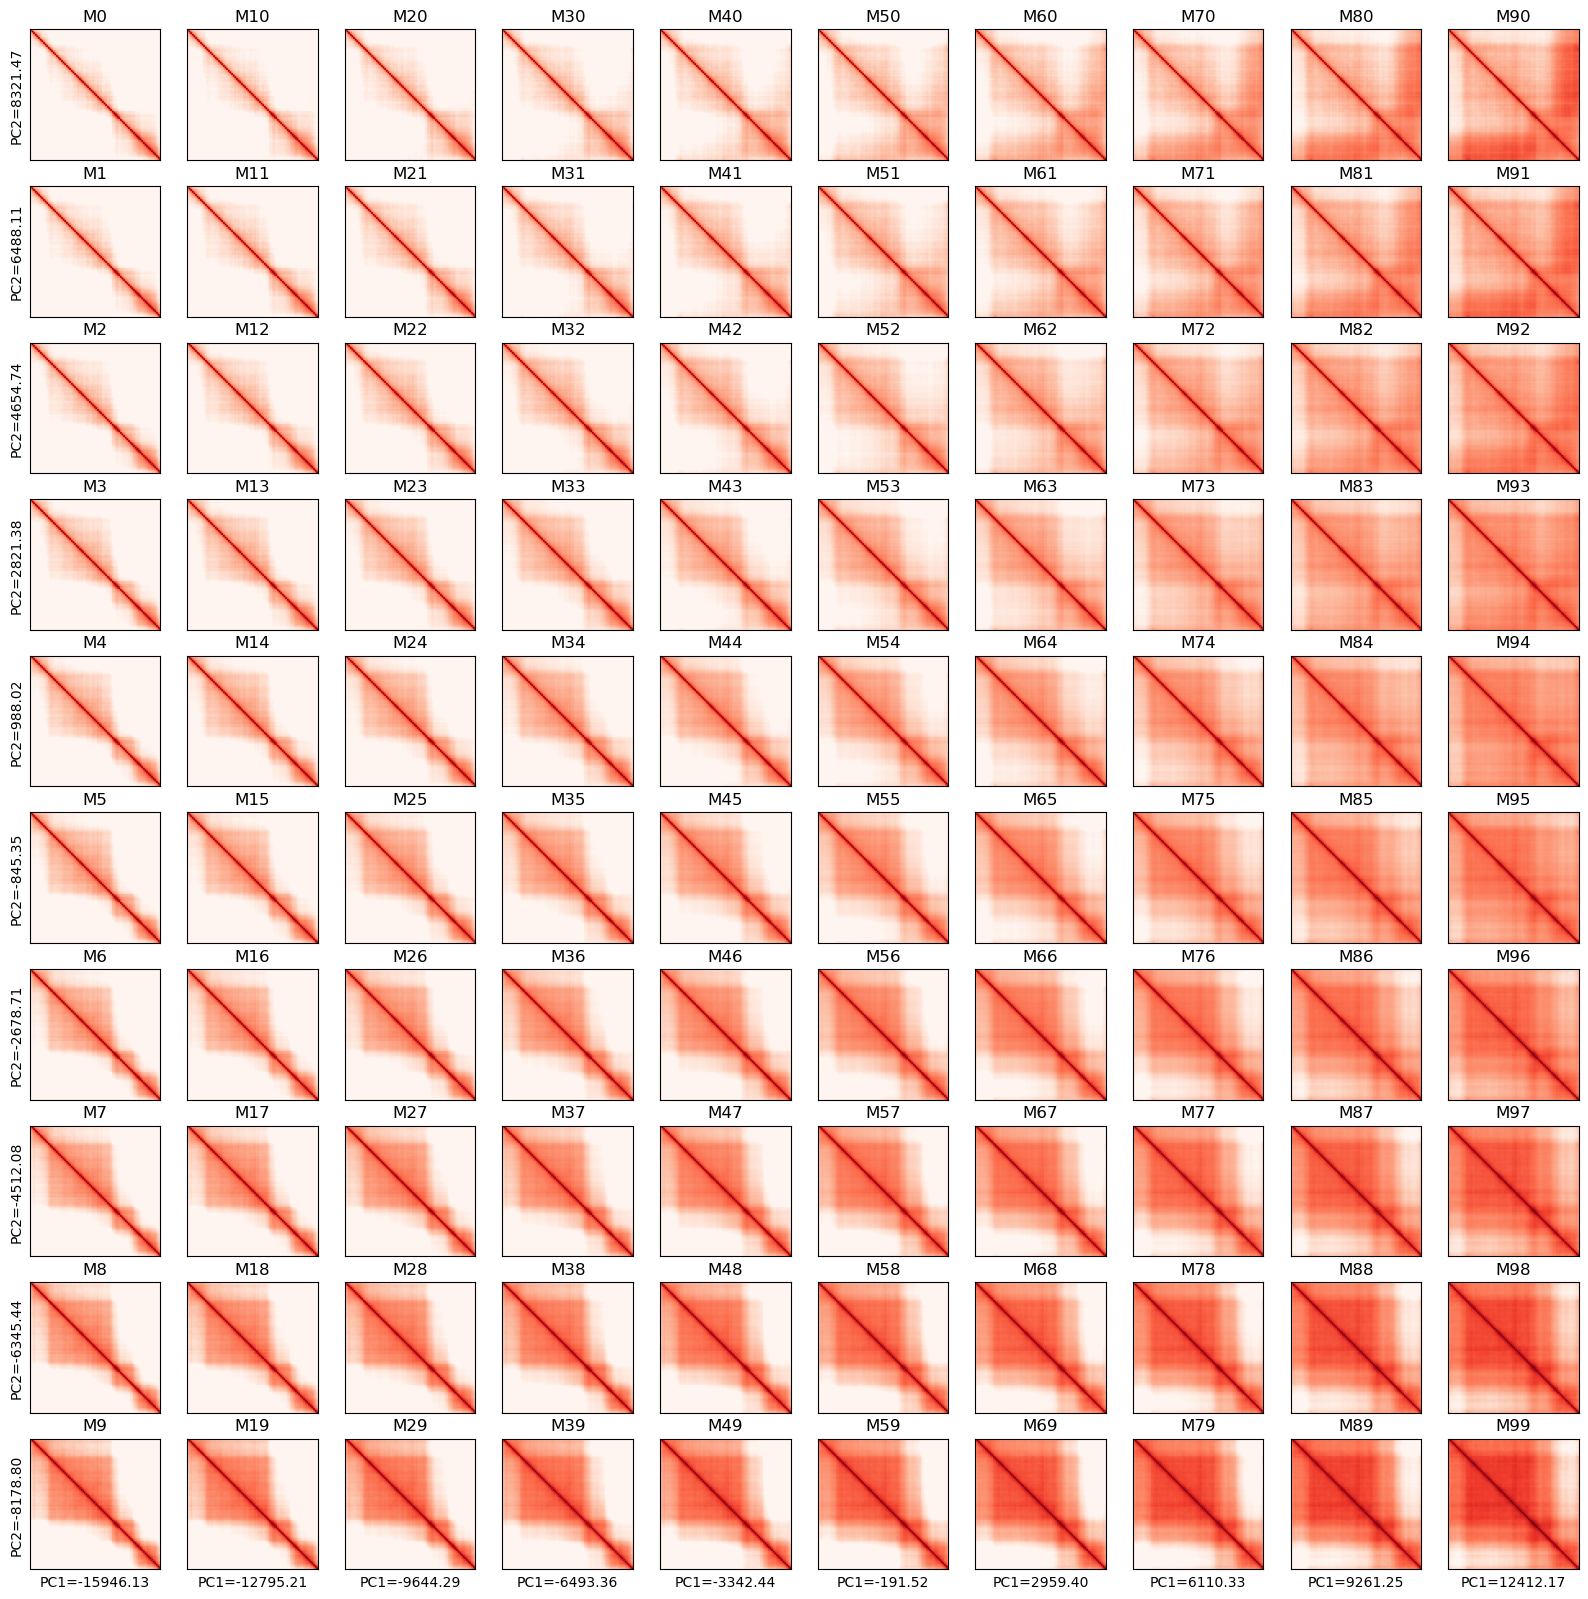

In [20]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    ax=axes[i%10, i//10]
    ax.imshow(metastructure_mean[i].reshape(80, 80), cmap='Reds_r', vmax=700)
    
    # axs[i//10, i%10].axis('off')
    # if ax is in the first col, add a y label
    lab = unique_combinations.iloc[i, 1]
    if i // 10 == 0:
        ax.set_ylabel(f'PC2={unique_combinations.iloc[i, 1]:.2f}')
    # if ax is in the last row, add a x label
    if i % 10 == 9:
        ax.set_xlabel(f'PC1={unique_combinations.iloc[i, 0]:.2f}')
        
    # Remove ticks by setting them to an empty list
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title('M{}'.format(i))
plt.savefig(os.path.join(save_dir, 'metastructures_PC1_PC2_physical.png'), dpi=300, bbox_inches='tight')
